In [1]:
!pip install transformers==4.31.0
import tensorflow as tf
from transformers import AutoTokenizer, TFBertForSequenceClassification
from google.colab import drive
!pip install iterative-stratification
import transformers
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
from transformers import AutoTokenizer, TFBertForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import os
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
balanced_df=pd.read_csv('/content/drive/Shareddrives/PFA/balanced.csv',lineterminator='\n')
model = tf.keras.models.load_model("/content/drive/Shareddrives/PFA/nlp-model.h5", custom_objects={"TFBertForSequenceClassification": TFBertForSequenceClassification})
cv_model = tf.keras.models.load_model("/content/drive/Shareddrives/PFA/xception6x6.h5")


In [3]:
#Configure Strategy. Assume TPU...if not set default for GPU/CPU
import tensorflow as tf
import random
import numpy as np
import pandas as pd

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    strategy = tf.distribute.MirroredStrategy()  # Use MirroredStrategy for multi-GPU training
    print('Running on GPU')
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()

# Seeds
def set_seeds(seed: int)->None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Generic Constants
MAX_LEN = 512
TEST_SIZE = 0.2
LR = 0.00002
VERBOSE = 1
SEED = 1000
set_seeds(SEED)

# Set Autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set Batch Size
BASE_BATCH_SIZE = 8         # Modify to match your GPU card.
if tpu is not None:
    BASE_BATCH_SIZE = BASE_BATCH_SIZE * 2    # TPU v2 or up...
BATCH_SIZE = BASE_BATCH_SIZE * strategy.num_replicas_in_sync

Running on TPU  


In [4]:
def create_dataset(texts, labels, tokenizer, batch_size, shuffle = False):
    # Placeholders input
    input_ids, input_masks = [], []

    # Placeholder output

    # Tokenize
    for index, text in enumerate(texts):
        # Encode
        input_encoded = tokenizer.encode_plus(text, add_special_tokens = True, max_length = MAX_LEN, truncation = True, padding = 'max_length')
        input_ids.append(input_encoded['input_ids'])
        input_masks.append(input_encoded['attention_mask'])

    # Prepare and Create TF Dataset.
    all_input_ids = tf.Variable(input_ids)
    all_input_masks = tf.Variable(input_masks)
    all_labels = tf.Variable(labels)
    dataset =  tf.data.Dataset.from_tensor_slices(({'input_ids': all_input_ids,
                                                    'attention_mask': all_input_masks},
                                                    all_labels))
    if shuffle:
        dataset = dataset.shuffle(128, reshuffle_each_iteration = True)
    dataset = dataset.batch(batch_size, drop_remainder = False)
    return dataset

In [10]:
from tensorflow.io import FixedLenFeature, parse_single_example, decode_raw
from functools import partial
from tensorflow.keras.applications.xception import preprocess_input
N_LABELS = 10 # Number of output labels
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(factor=0.2),
])
import pickle
batches = '/content/drive/Shareddrives/PFA/batches'

IMAGES_NUMBER=36

def import_processed_images(username):
    """
    Load the batch file for a specific username.
    """
    # Create the filename for the user's batch file
    batch_filename = os.path.join(batches, f"{username}.pkl")
    # Check if the file exists
    if os.path.exists(batch_filename):
        try:
            # Open the batch file and load the data
            with open(batch_filename, 'rb') as file:
                data = pickle.load(file)
                return data[:IMAGES_NUMBER]
                #return np.array(data)

        except Exception as e:
            # Handle any errors that occur during file loading
            print(f"Error loading batch file for {username}: {e}")
            return []
    else:
        print(f"......No batch file found for {username}.......")
        return []

def augment_images(images):
    #tf.print('augmenting')
    return data_augmentation(images, training=True)

def concatenate_images(images, grid_size=(6, 6)):
    rows, cols = grid_size
    img_height, img_width, channels = images.shape[1:4]

    # Reshape images into a grid
    images = tf.reshape(images, (rows, cols, img_height, img_width, channels))
    # Concatenate along width (cols)
    row_images = [tf.concat(list(images[row]), axis=1) for row in range(rows)]
    # Concatenate along height (rows)
    mosaic_image = tf.concat(row_images, axis=0)

    return mosaic_image

def create_tf_dataset(filenames, labels, batch_size=64, training=False):
    def data_generator():
        for filename, label in zip(filenames, labels):
            images = import_processed_images(filename)  # shape should be (IMAGES_NUMBER, 224, 224, 3)
            #images = [preprocess_input(image*255) for image in images]
            mosaic=concatenate_images(images)
            yield mosaic, label

    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape=(224*6, 224*6, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(N_LABELS,), dtype=tf.float32)
        )
    )

    dataset = dataset.cache()

    if training:
        dataset = dataset.shuffle(128, reshuffle_each_iteration = True)  # Adjust as needed
        dataset = dataset.map(lambda x, y: (augment_images(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [11]:
import pandas as pd
balanced_df=pd.read_csv('/content/drive/Shareddrives/PFA/balanced.csv',lineterminator='\n')


In [12]:
# Group the data by category
from sklearn.preprocessing import MultiLabelBinarizer
text = list(balanced_df['text'].values)
label = MultiLabelBinarizer()
images= list(balanced_df['username'].values)
balanced_df['categories'] = balanced_df['categories'].apply(lambda x: eval(x) if isinstance(x, str) else x)
#print(balanced_df[['text', 'categories']].iloc[50:100])
category_counts = balanced_df['categories'].explode().value_counts()
y = label.fit_transform(balanced_df['categories'])

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

num_labels=y.shape[1]
X = np.array(text)
y = np.array(y)
z = np.array(images)

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in msss.split(X, y, z):
   train_texts, test_texts = X[train_index], X[test_index]
   train_labels, test_labels = y[train_index], y[test_index]
   train_filenames, test_filenames = z[train_index], z[test_index]

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# Create TensorFlow datasets
train_dataset = create_dataset(train_texts,train_labels,tokenizer,BASE_BATCH_SIZE,True)
test_dataset = create_dataset(test_texts,test_labels,tokenizer,BASE_BATCH_SIZE,False)

train_dataset_unshuff=create_dataset(train_texts,train_labels,tokenizer,BASE_BATCH_SIZE,False)
train_ds_unshuff=create_tf_dataset(train_filenames,train_labels,BASE_BATCH_SIZE,False)

train_ds = create_tf_dataset(train_filenames,train_labels,BASE_BATCH_SIZE,True)
test_ds = create_tf_dataset(test_filenames,test_labels,BASE_BATCH_SIZE,False)

**Concatenate models**

In [24]:
import transformers
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
from transformers import AutoTokenizer, TFBertForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.multioutput import MultiOutputClassifier
import os
with strategy.scope():
  y_pred_train_cv = cv_model.predict(train_ds_unshuff)
  y_train = np.concatenate([y for x, y in train_ds_unshuff], axis=0)
  y_pred_train_nlp = model.predict(train_dataset_unshuff)
  combined_train_predictions = np.hstack((y_pred_train_nlp, y_pred_train_cv))


  # Train a logistic regression model as the meta-learner
  meta_learner = MultiOutputClassifier(LogisticRegression())
  meta_learner.fit(combined_train_predictions, y_train)

  # Evaluate on the validation set
  meta_val_predictions = meta_learner.predict(combined_train_predictions)
  train_accuracy = accuracy_score(y_train, meta_val_predictions)
  print(f"Train Accuracy: {train_accuracy}")
  # Get predictions from individual models on test data
  bert_test_predictions = model.predict(test_dataset)
  xception_test_predictions = cv_model.predict(test_ds)

  # Combine test predictions
  combined_test_predictions = np.hstack((bert_test_predictions, xception_test_predictions))

  # Use the meta-learner to get the final test predictions
  meta_test_predictions = meta_learner.predict(combined_test_predictions)

  y_test = np.concatenate([y for x, y in test_dataset], axis=0)
  #print(y_pred[0], y_test[0])
  threshold = 0.4  # Adjust as needed

  # Convert probabilities to binary predictions using the threshold
  y_pred= np.where(meta_test_predictions > threshold, 1, 0)
print('Classification Report', classification_report(y_test,y_pred, target_names=label.classes_), sep='\n')


9/9 [==============================] - 5s 412ms/step
Classification Report
                  precision    recall  f1-score   support

          Acting       0.81      0.76      0.79        17
         Animals       1.00      0.80      0.89        15
          Doctor       1.00      0.53      0.70        15
       Education       0.77      0.62      0.69        16
Fashion & Beauty       0.38      0.33      0.36        15
            Food       0.88      0.93      0.90        15
           Music       0.92      0.80      0.86        15
   Personal Blog       0.67      0.70      0.68        23
          Sports       0.88      0.94      0.91        16
          Travel       0.62      0.50      0.55        16

       micro avg       0.78      0.69      0.73       163
       macro avg       0.79      0.69      0.73       163
    weighted avg       0.79      0.69      0.73       163
     samples avg       0.75      0.73      0.73       163



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


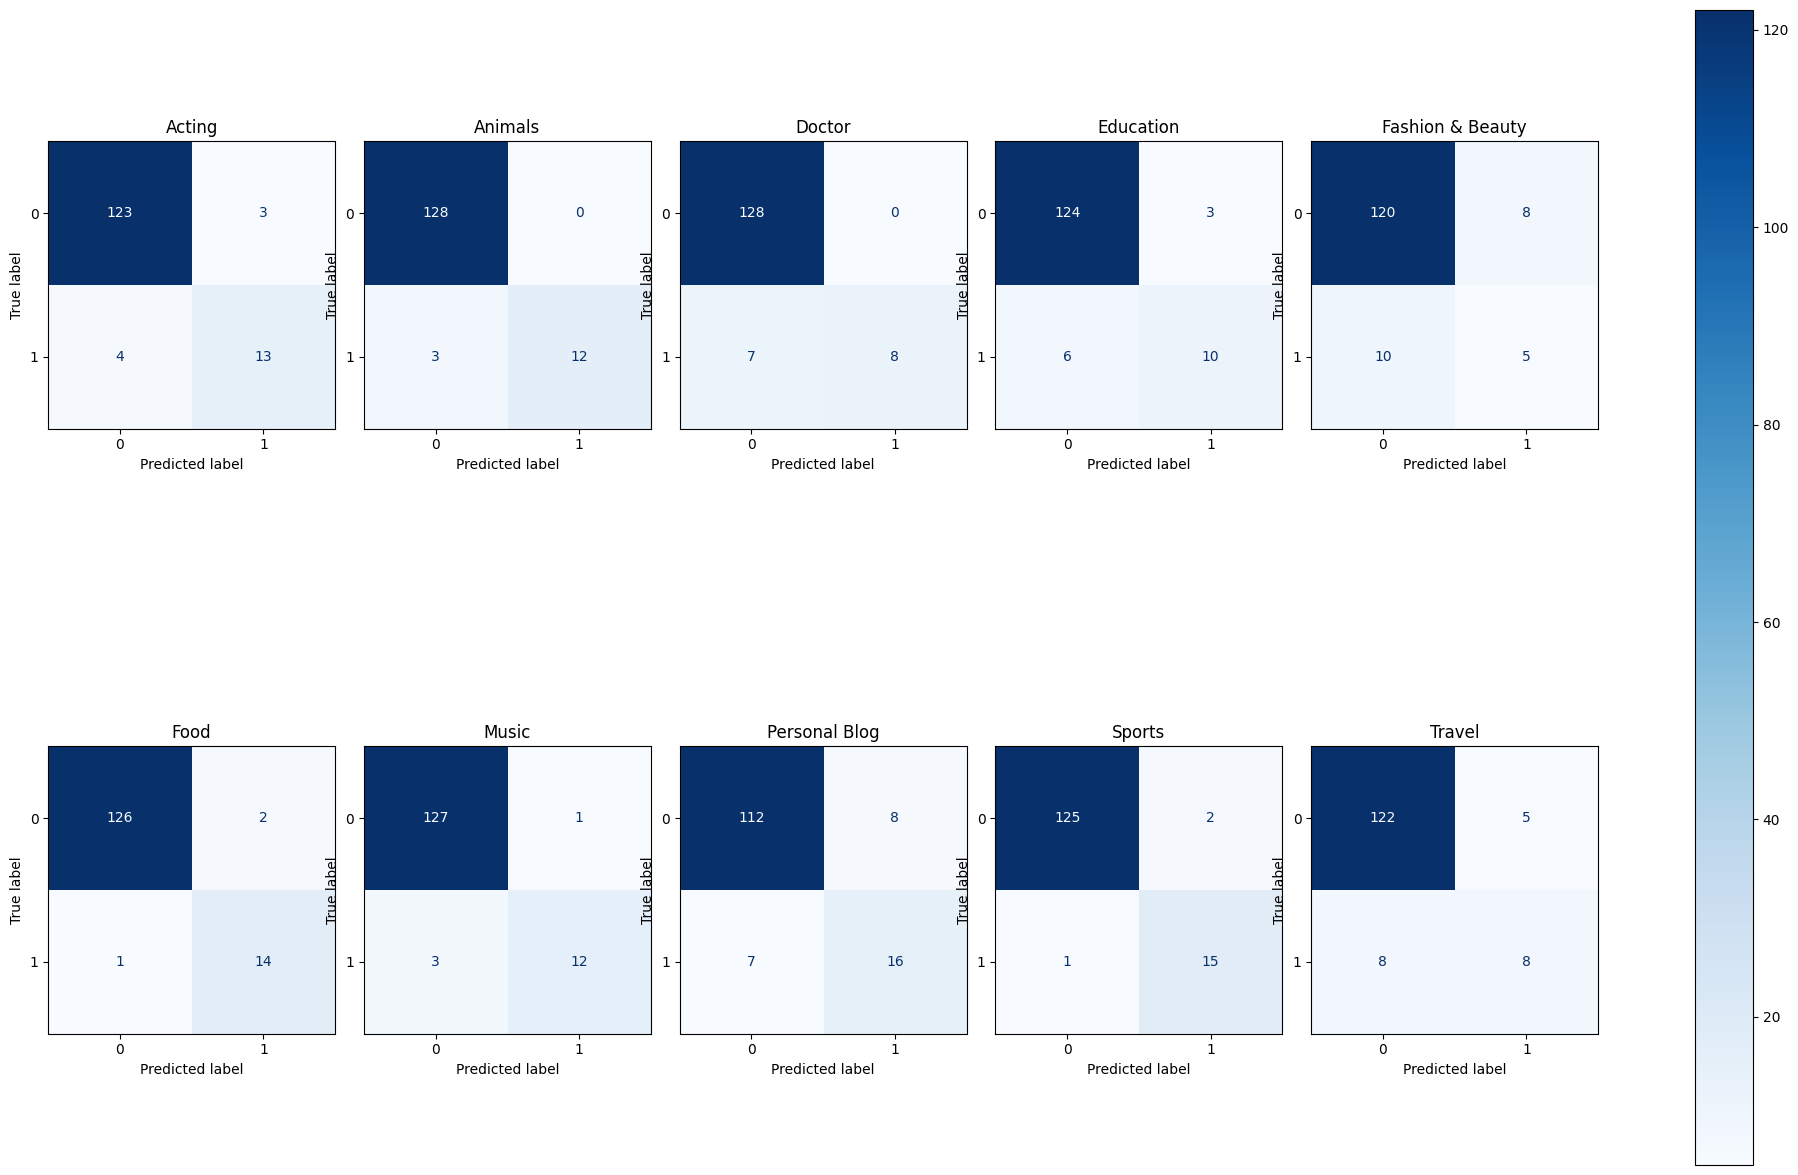

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# Compute the confusion matrix
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)
f, axes = plt.subplots(2, 5, figsize=(25, 15))
axes = axes.ravel()
cmap = sns.color_palette("Blues", as_cmap=True)
# Print the confusion matrix for each class
for i in range(num_labels):
    disp = ConfusionMatrixDisplay(conf_matrix[i],display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g',cmap=cmap)
    disp.ax_.set_title(label.classes_[i])
    disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

**Evaluation**

In [25]:
class_of_interest = 0  # Class you're interested in
# Iterate through the test data and predictions
for idx, (test_data, prediction) in enumerate(zip(y_test, y_pred)):
    # Check if the prediction matches the class of interest
    if prediction[class_of_interest] == 1:
      print(f"Instance {idx+1} {test_filenames[idx]}: {[x for i,x in enumerate(label.classes_) if  prediction[i]== 1]}, Predicted: {[x for i,x in enumerate(label.classes_) if  y_pred[idx][i]== 1]}")

Instance 19 raniagabsi: ['Acting'], Predicted: ['Acting']
Instance 22 hendsabri: ['Acting'], Predicted: ['Acting']
Instance 23 leilabenkhalifaofficial: ['Acting'], Predicted: ['Acting']
Instance 27 rabebhosny: ['Acting'], Predicted: ['Acting']
Instance 91 nada_mezni_hafaiedh: ['Acting'], Predicted: ['Acting']
Instance 99 yacineben_osman: ['Acting'], Predicted: ['Acting']
Instance 133 wassime_baccouche: ['Acting'], Predicted: ['Acting']
Instance 134 laajimiahmed: ['Acting'], Predicted: ['Acting']
Instance 136 gharbiikarim: ['Acting'], Predicted: ['Acting']
Instance 137 zynemastouri: ['Acting'], Predicted: ['Acting']
Instance 138 rymriahi: ['Acting'], Predicted: ['Acting']
Instance 139 nahdi.dali.officiel: ['Acting'], Predicted: ['Acting']
Instance 140 dhaferlabidine: ['Acting'], Predicted: ['Acting']
Instance 141 wahida.dridi.officiel: ['Acting'], Predicted: ['Acting']
Instance 142 mohamed.dahech_officiel: ['Acting'], Predicted: ['Acting']
Instance 143 mohamedlotfyofficial: ['Acting'], 